In [ ]:
import requests

# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To hit our API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = { "id": "ttc-streetcar-delay-data"}
package = requests.get(url, params = params).json()

# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]):
    print('{idx}, {name}, {resource}'.format(idx=idx, name=resource['name'], resource=resource))

    # To get metadata for non datastore_active resources:
    if not resource["datastore_active"]:
        url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
        resource_metadata = requests.get(url).json()
        print(resource_metadata)
        # From here, you can use the "url" attribute to download this file

In [ ]:
for idx, resource in enumerate(package["result"]["resources"]):
    xlsx_url = resource["url"]
    response = requests.get(xlsx_url)
    
    if response.status_code == 200:
        resourcename = resource['name'].replace("\t","") # This code is to take into account a naming error at datasource
        
        # Save streetcar data as .xlsx file
        xlsx_filename = f"{resourcename}.xlsx"
        with open(xlsx_filename, "wb") as file:
            file.write(response.content)
        print(f"XLSX resource downloaded successfully. Check '{xlsx_filename}' file.")
    else:
        print("Failed to download the XLSX resource.")
        break  # Exit the loop if there was an error

In [88]:
import pandas as pd
import numpy as np
from datetime import date
import calendar
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [146]:
df = pd.read_excel('ttc-streetcar-delay-data-2022.xlsx')
df

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2022-01-01,504,02:21,Saturday,BROADVIEW STATION,Collision - TTC Involved,30,60,E,8333
1,2022-01-01,501,03:22,Saturday,718 QUEEN ST EAST,Operations,16,35,W,8068
2,2022-01-01,504,03:28,Saturday,BROADVIEW STATION,Operations,18,36,S,0
3,2022-01-01,510,03:34,Saturday,UNION STATION,Operations,30,60,NaN,4406
4,2022-01-01,301,03:39,Saturday,LAKESHORE AND TENTH,Security,5,25,W,8622
...,...,...,...,...,...,...,...,...,...,...
17650,2022-12-31,504,01:20,Saturday,KING AND PORTLAND,Cleaning - Unsanitary,10,20,E,4588
17651,2022-12-31,510,01:24,Saturday,UNION STATION,Security,10,20,N,4463
17652,2022-12-31,501,01:42,Saturday,KINGSTON LOOP,Security,0,0,NaN,4534
17653,2022-12-31,504,01:46,Saturday,KING AND PETER,Cleaning - Unsanitary,10,20,W,4431


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17655 entries, 0 to 17654
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       17655 non-null  datetime64[ns]
 1   Line       17612 non-null  object        
 2   Time       17655 non-null  object        
 3   Day        17655 non-null  object        
 4   Location   17655 non-null  object        
 5   Incident   17655 non-null  object        
 6   Min Delay  17655 non-null  int64         
 7   Min Gap    17655 non-null  int64         
 8   Bound      14606 non-null  object        
 9   Vehicle    17655 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 1.3+ MB


In [148]:
df.dropna()

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2022-01-01,504,02:21,Saturday,BROADVIEW STATION,Collision - TTC Involved,30,60,E,8333
1,2022-01-01,501,03:22,Saturday,718 QUEEN ST EAST,Operations,16,35,W,8068
2,2022-01-01,504,03:28,Saturday,BROADVIEW STATION,Operations,18,36,S,0
4,2022-01-01,301,03:39,Saturday,LAKESHORE AND TENTH,Security,5,25,W,8622
5,2022-01-01,501,03:42,Saturday,BROADVIEW AND GERRARD,Operations,10,20,W,8847
...,...,...,...,...,...,...,...,...,...,...
17649,2022-12-31,504,01:15,Saturday,KING AND SPADINA,Utilized Off Route,10,220,W,4558
17650,2022-12-31,504,01:20,Saturday,KING AND PORTLAND,Cleaning - Unsanitary,10,20,E,4588
17651,2022-12-31,510,01:24,Saturday,UNION STATION,Security,10,20,N,4463
17653,2022-12-31,504,01:46,Saturday,KING AND PETER,Cleaning - Unsanitary,10,20,W,4431


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17655 entries, 0 to 17654
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       17655 non-null  datetime64[ns]
 1   Line       17612 non-null  object        
 2   Time       17655 non-null  object        
 3   Day        17655 non-null  object        
 4   Location   17655 non-null  object        
 5   Incident   17655 non-null  object        
 6   Min Delay  17655 non-null  int64         
 7   Min Gap    17655 non-null  int64         
 8   Bound      14606 non-null  object        
 9   Vehicle    17655 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 1.3+ MB


In [150]:
data1 = df.groupby(['Bound']).aggregate({'Min Delay':'sum'})
data1

,Min Delay
Bound,
5,8
B,4627
C,16
E,78326
N,21961
Q,8
S,22958
T,13
W,78945


In [151]:
df = df[df.Bound != "C"]
df = df[df.Bound != "5"]
df = df[df.Bound != "Q"]
df = df[df.Bound != "T"]

In [152]:
df

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2022-01-01,504,02:21,Saturday,BROADVIEW STATION,Collision - TTC Involved,30,60,E,8333
1,2022-01-01,501,03:22,Saturday,718 QUEEN ST EAST,Operations,16,35,W,8068
2,2022-01-01,504,03:28,Saturday,BROADVIEW STATION,Operations,18,36,S,0
3,2022-01-01,510,03:34,Saturday,UNION STATION,Operations,30,60,NaN,4406
4,2022-01-01,301,03:39,Saturday,LAKESHORE AND TENTH,Security,5,25,W,8622
...,...,...,...,...,...,...,...,...,...,...
17650,2022-12-31,504,01:20,Saturday,KING AND PORTLAND,Cleaning - Unsanitary,10,20,E,4588
17651,2022-12-31,510,01:24,Saturday,UNION STATION,Security,10,20,N,4463
17652,2022-12-31,501,01:42,Saturday,KINGSTON LOOP,Security,0,0,NaN,4534
17653,2022-12-31,504,01:46,Saturday,KING AND PETER,Cleaning - Unsanitary,10,20,W,4431


In [ ]:
#data1 = df.groupby(['Bound']).aggregate({'Min Delay':'sum'})
#data1

In [ ]:
#data2 = df.groupby(['Day']).aggregate({'Min Delay':'sum'})
#data2

In [ ]:
#data2 = df.groupby(['Line']).aggregate({'Min Delay':'sum'})
#data2

In [153]:
df = df[df.Line != 41]
df = df[df.Line != 47]
df = df[df.Line != 54]
df = df[df.Line != 88]
df = df[df.Line != 300]
df = df[df.Line != 500]
df = df[df.Line != 508]
df = df[df.Line != 555]
df = df[df.Line != 600]
df = df[df.Line != 705]
df = df[df.Line != 960]
df = df[df.Line != 999]
df = df[df.Line != 5014]
df = df[df.Line != "(RAD"]
df = df[df.Line != "OTC"]
df = df[df.Line != "RAD"]

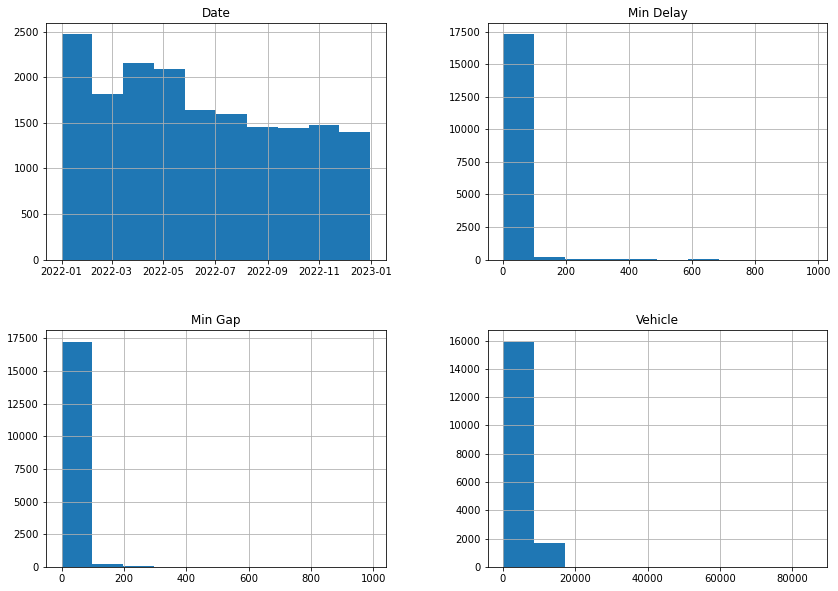

In [90]:
df.hist(figsize=(14,10))
plt.show()

<AxesSubplot:xlabel='Line', ylabel='count'>

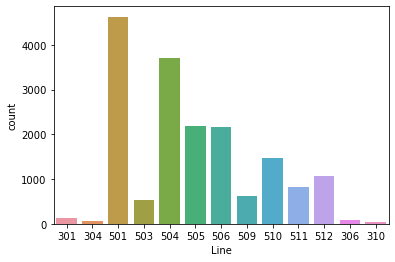

In [154]:
sns.countplot(data = df, x = 'Line')

<AxesSubplot:xlabel='Day', ylabel='count'>

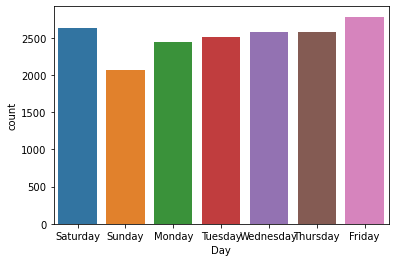

In [164]:
sns.countplot(data = df, x = 'Day')

<AxesSubplot:xlabel='Line', ylabel='Min Delay'>

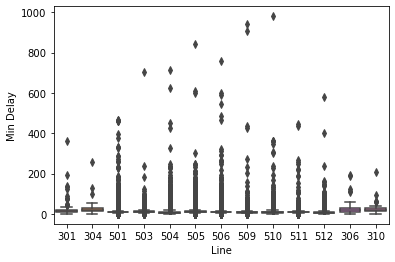

In [155]:
sns.boxplot(x = df['Line'], 
            y = df['Min Delay'])

<AxesSubplot:xlabel='Day', ylabel='Min Delay'>

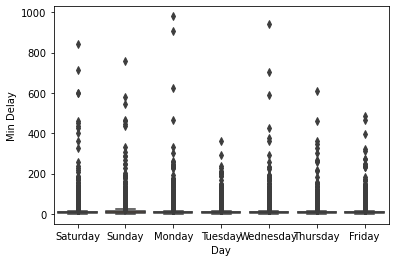

In [156]:
sns.boxplot(x = df['Day'], 
            y = df['Min Delay'])

In [ ]:
#data2 = df.groupby(['Line']).aggregate({'Min Delay':'sum'})
#data2

In [ ]:
#pivot_table_1 = np.round(pd.pivot_table(df, values='Min Delay', 
#                                index=['Line'], 
#                                columns=['Bound'], 
#                                aggfunc=[np.sum],
#                                fill_value=0,
#                                margins=True, margins_name='Total'),2)
#pivot_table_1

In [157]:
df["Min Delay"].describe()

count    17575.000000
mean        14.288421
std         33.010616
min          0.000000
25%          6.000000
50%          8.000000
75%         10.000000
max        980.000000
Name: Min Delay, dtype: float64

In [140]:
df_test = df.rename(columns={"Min Delay": "Delay"}, errors="raise")
df_test
df_test["Delay"].describe()

count    17575.000000
mean        14.288421
std         33.010616
min          0.000000
25%          6.000000
50%          8.000000
75%         10.000000
max        980.000000
Name: Delay, dtype: float64

In [161]:
df_test = df.drop(df_test[df_test['Min Delay'] > 50].index)
df_test["Min Delay"].describe()

count    16907.000000
mean         9.839002
std          7.373018
min          0.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         50.000000
Name: Min Delay, dtype: float64

<AxesSubplot:xlabel='Day', ylabel='Min Delay'>

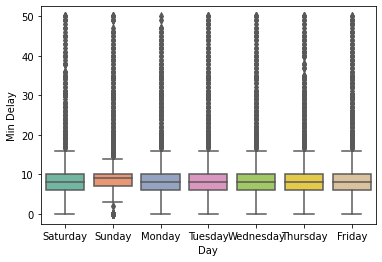

In [162]:
sns.boxplot(x = df_test['Day'], 
            y = df_test['Min Delay'],  
            palette = 'Set2') 

In [9]:
streetcars_510 = df[df["Line"] == 510]

In [10]:
streetcars_510

,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
3,2022-01-01,510,03:34,Saturday,UNION STATION,Operations,30,60,NaN,4406
16,2022-01-01,510,08:31,Saturday,SPADINA STATION,Operations,9,19,W,0
18,2022-01-01,510,08:53,Saturday,SPADINA STATION,Operations,9,19,W,0
19,2022-01-01,510,08:57,Saturday,SPADINA STATION,Operations,9,19,W,0
21,2022-01-01,510,09:04,Saturday,SPADINA STATION,Operations,9,18,W,0
...,...,...,...,...,...,...,...,...,...,...
17605,2022-12-30,510,01:30,Friday,PARLIAMENT AND QUEEN,Security,9,18,N,4602
17607,2022-12-30,510,01:57,Friday,UNION STATION,Diversion,14,29,NaN,4419
17616,2022-12-31,510,11:15,Saturday,SPADINA AND QUEEN,Operations,4,8,N,4490
17643,2022-12-31,510,22:30,Saturday,SPADINA AND QUEENS QUA,General Delay,0,0,NaN,0


In [11]:
streetcars_510_2 = streetcars_510.drop(['Location', 'Vehicle', 'Incident', 'Min Gap'], axis=1)

In [12]:
streetcars_510_2

,Date,Line,Time,Day,Min Delay,Bound
3,2022-01-01,510,03:34,Saturday,30,NaN
16,2022-01-01,510,08:31,Saturday,9,W
18,2022-01-01,510,08:53,Saturday,9,W
19,2022-01-01,510,08:57,Saturday,9,W
21,2022-01-01,510,09:04,Saturday,9,W
...,...,...,...,...,...,...
17605,2022-12-30,510,01:30,Friday,9,N
17607,2022-12-30,510,01:57,Friday,14,NaN
17616,2022-12-31,510,11:15,Saturday,4,N
17643,2022-12-31,510,22:30,Saturday,0,NaN


In [13]:
streetcars_510_2 = streetcars_510_2.dropna()

In [14]:
streetcars_510_2

,Date,Line,Time,Day,Min Delay,Bound
16,2022-01-01,510,08:31,Saturday,9,W
18,2022-01-01,510,08:53,Saturday,9,W
19,2022-01-01,510,08:57,Saturday,9,W
21,2022-01-01,510,09:04,Saturday,9,W
22,2022-01-01,510,09:20,Saturday,5,W
...,...,...,...,...,...,...
17578,2022-12-30,510,11:52,Friday,10,S
17582,2022-12-30,510,12:03,Friday,10,W
17605,2022-12-30,510,01:30,Friday,9,N
17616,2022-12-31,510,11:15,Saturday,4,N


In [15]:
streetcars_510_2['Time'] = pd.to_datetime(streetcars_510_2['Time'])
print(streetcars_510_2)

            Date Line                Time       Day  Min Delay Bound
16    2022-01-01  510 2024-04-01 08:31:00  Saturday          9     W
18    2022-01-01  510 2024-04-01 08:53:00  Saturday          9     W
19    2022-01-01  510 2024-04-01 08:57:00  Saturday          9     W
21    2022-01-01  510 2024-04-01 09:04:00  Saturday          9     W
22    2022-01-01  510 2024-04-01 09:20:00  Saturday          5     W
...          ...  ...                 ...       ...        ...   ...
17578 2022-12-30  510 2024-04-01 11:52:00    Friday         10     S
17582 2022-12-30  510 2024-04-01 12:03:00    Friday         10     W
17605 2022-12-30  510 2024-04-01 01:30:00    Friday          9     N
17616 2022-12-31  510 2024-04-01 11:15:00  Saturday          4     N
17651 2022-12-31  510 2024-04-01 01:24:00  Saturday         10     N

[1197 rows x 6 columns]


C:\Users\shaikhl2\AppData\Local\Temp\ipykernel_7516\2674934658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streetcars_510_2['Time'] = pd.to_datetime(streetcars_510_2['Time'])


In [16]:
streetcars_510_2

,Date,Line,Time,Day,Min Delay,Bound
16,2022-01-01,510,2024-04-01 08:31:00,Saturday,9,W
18,2022-01-01,510,2024-04-01 08:53:00,Saturday,9,W
19,2022-01-01,510,2024-04-01 08:57:00,Saturday,9,W
21,2022-01-01,510,2024-04-01 09:04:00,Saturday,9,W
22,2022-01-01,510,2024-04-01 09:20:00,Saturday,5,W
...,...,...,...,...,...,...
17578,2022-12-30,510,2024-04-01 11:52:00,Friday,10,S
17582,2022-12-30,510,2024-04-01 12:03:00,Friday,10,W
17605,2022-12-30,510,2024-04-01 01:30:00,Friday,9,N
17616,2022-12-31,510,2024-04-01 11:15:00,Saturday,4,N


In [17]:
streetcars_510_2['Time'] = streetcars_510_2['Time'].dt.round('10min')

C:\Users\shaikhl2\AppData\Local\Temp\ipykernel_7516\3135350365.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streetcars_510_2['Time'] = streetcars_510_2['Time'].dt.round('10min')


In [18]:
streetcars_510_2

,Date,Line,Time,Day,Min Delay,Bound
16,2022-01-01,510,2024-04-01 08:30:00,Saturday,9,W
18,2022-01-01,510,2024-04-01 08:50:00,Saturday,9,W
19,2022-01-01,510,2024-04-01 09:00:00,Saturday,9,W
21,2022-01-01,510,2024-04-01 09:00:00,Saturday,9,W
22,2022-01-01,510,2024-04-01 09:20:00,Saturday,5,W
...,...,...,...,...,...,...
17578,2022-12-30,510,2024-04-01 11:50:00,Friday,10,S
17582,2022-12-30,510,2024-04-01 12:00:00,Friday,10,W
17605,2022-12-30,510,2024-04-01 01:30:00,Friday,9,N
17616,2022-12-31,510,2024-04-01 11:20:00,Saturday,4,N


In [19]:
streetcars_510_2.loc[streetcars_510_2["Bound"] == "W", "Bound"] = "N"

In [20]:
streetcars_510_2.loc[streetcars_510_2["Bound"] == "E", "Bound"] = "S"

In [21]:
data2 = streetcars_510_2.groupby(['Bound']).aggregate({'Min Delay':'sum'})
data2

,Min Delay
Bound,
B,412
N,7784
S,8527


In [22]:
streetcars_510_2['hour'] = streetcars_510_2['Time'].dt.hour

C:\Users\shaikhl2\AppData\Local\Temp\ipykernel_7516\1066868831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streetcars_510_2['hour'] = streetcars_510_2['Time'].dt.hour


In [25]:
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 0]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 1]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 2]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 3]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 4]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 5]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 6]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 22]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 23]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.hour != 24]
streetcars_510_2 = streetcars_510_2[streetcars_510_2.Day != "Sunday"]

In [26]:
streetcars_510_2

,Date,Line,Time,Day,Min Delay,Bound,hour
16,2022-01-01,510,2024-04-01 08:30:00,Saturday,9,N,8
18,2022-01-01,510,2024-04-01 08:50:00,Saturday,9,N,8
19,2022-01-01,510,2024-04-01 09:00:00,Saturday,9,N,9
21,2022-01-01,510,2024-04-01 09:00:00,Saturday,9,N,9
22,2022-01-01,510,2024-04-01 09:20:00,Saturday,5,N,9
...,...,...,...,...,...,...,...
17536,2022-12-28,510,2024-04-01 19:20:00,Wednesday,10,S,19
17547,2022-12-29,510,2024-04-01 07:50:00,Thursday,4,N,7
17578,2022-12-30,510,2024-04-01 11:50:00,Friday,10,S,11
17582,2022-12-30,510,2024-04-01 12:00:00,Friday,10,N,12


In [124]:
streetcars_510_2["Min Delay"].describe()

count    767.000000
mean      12.621904
std       38.661522
min        0.000000
25%        5.000000
50%        8.000000
75%       10.000000
max      980.000000
Name: Min Delay, dtype: float64

<AxesSubplot:xlabel='Day', ylabel='count'>

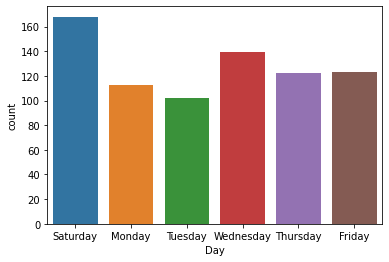

In [165]:
sns.countplot(data = streetcars_510_2, x = 'Day')

In [125]:
streetcars_510_2_test = streetcars_510_2.rename(columns={"Min Delay": "Delay"}, errors="raise")
streetcars_510_2_test
streetcars_510_2_test = streetcars_510_2_test.drop(streetcars_510_2_test[streetcars_510_2_test.Delay > 50].index)

<AxesSubplot:xlabel='Day', ylabel='Delay'>

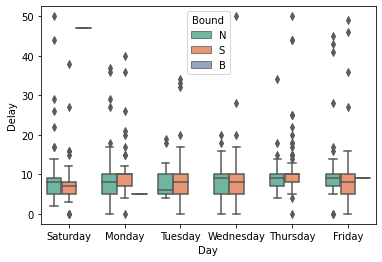

In [126]:
sns.boxplot(x = streetcars_510_2_test['Day'], 
            y = streetcars_510_2_test['Delay'], 
            hue = streetcars_510_2_test['Bound'], 
            palette = 'Set2') 

<AxesSubplot:xlabel='Day', ylabel='Delay'>

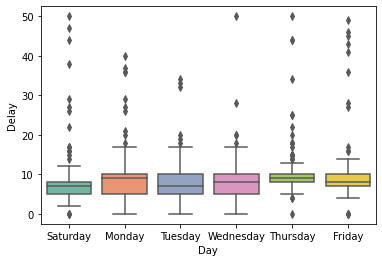

In [163]:
sns.boxplot(x = streetcars_510_2_test['Day'], 
            y = streetcars_510_2_test['Delay'],
            palette = 'Set2') 

In [ ]:
### Create time frame. Use the existing delay data to match the dataframe -- replace existing values

In [ ]:
#tdIndex = pd.timedelta_range("4:00:00", "23:00:00", freq="10min")

In [ ]:
#tdIndex

In [ ]:
#print("TimedeltaIndex...\n", tdIndex)

In [ ]:
#print("\nThe Dataframe of the components of TimeDeltas...\n", tdIndex.components)
#print("\nTimeDeltaIndex to DataFrame...\n", tdIndex.to_frame(index=False, name = 'DateTimeData'))

In [ ]:
#drange = pd.date_range('2022-01-01 00:00:00', freq='10T', periods=5)
#df = pd.DataFrame({'datetime': drange.tolist() + (drange+pd.DateOffset(days=1)).tolist(),
#                   'Value_1':np.random.randint(10, size=10),})

In [ ]:
#df

In [27]:
drange = pd.date_range('2022-01-01 00:00:00', freq='10T', periods=70000)
df_mock_schedule = pd.DataFrame({'datetime': drange.tolist() + (drange+pd.DateOffset(days=365)).tolist(),})
df_mock_schedule

,datetime
0,2022-01-01 00:00:00
1,2022-01-01 00:10:00
2,2022-01-01 00:20:00
3,2022-01-01 00:30:00
4,2022-01-01 00:40:00
...,...
139995,2024-05-01 01:50:00
139996,2024-05-01 02:00:00
139997,2024-05-01 02:10:00
139998,2024-05-01 02:20:00


In [28]:
#file_name = 'MarksData.xlsx'
#df_time_test.to_excel(file_name)
#print('DataFrame is written to Excel File successfully.')

In [29]:
#df_time_test1['date'] = pd.to_datetime(df['date'])
df_mock_schedule['Date'] = df_mock_schedule['datetime'].dt.date
df_mock_schedule['hour'] = df_mock_schedule['datetime'].dt.hour
df_mock_schedule['day'] = df_mock_schedule['datetime'].dt.day
df_mock_schedule['month'] = df_mock_schedule['datetime'].dt.month
df_mock_schedule['year'] = df_mock_schedule['datetime'].dt.year
df_mock_schedule['Day'] = df_mock_schedule['datetime'].dt.day_name()
df_mock_schedule['Line'] = '510'
df_mock_schedule['Min Delay'] = 0

In [30]:
df_mock_schedule

,datetime,Date,hour,day,month,year,Day,Line,Min Delay
0,2022-01-01 00:00:00,2022-01-01,0,1,1,2022,Saturday,510,0
1,2022-01-01 00:10:00,2022-01-01,0,1,1,2022,Saturday,510,0
2,2022-01-01 00:20:00,2022-01-01,0,1,1,2022,Saturday,510,0
3,2022-01-01 00:30:00,2022-01-01,0,1,1,2022,Saturday,510,0
4,2022-01-01 00:40:00,2022-01-01,0,1,1,2022,Saturday,510,0
...,...,...,...,...,...,...,...,...,...
139995,2024-05-01 01:50:00,2024-05-01,1,1,5,2024,Wednesday,510,0
139996,2024-05-01 02:00:00,2024-05-01,2,1,5,2024,Wednesday,510,0
139997,2024-05-01 02:10:00,2024-05-01,2,1,5,2024,Wednesday,510,0
139998,2024-05-01 02:20:00,2024-05-01,2,1,5,2024,Wednesday,510,0


In [31]:
df_mock_schedule = df_mock_schedule[df_mock_schedule.year != 2023]
df_mock_schedule = df_mock_schedule[df_mock_schedule.year != 2024]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 0]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 1]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 2]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 3]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 4]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 5]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 6]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 22]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 23]
df_mock_schedule = df_mock_schedule[df_mock_schedule.hour != 24]
df_mock_schedule = df_mock_schedule[df_mock_schedule.Day != "Sunday"]

In [32]:
df_mock_schedule = df_mock_schedule.rename(columns={"datetime": "Time"}, errors="raise")

In [33]:
df_mock_schedule

,Time,Date,hour,day,month,year,Day,Line,Min Delay
42,2022-01-01 07:00:00,2022-01-01,7,1,1,2022,Saturday,510,0
43,2022-01-01 07:10:00,2022-01-01,7,1,1,2022,Saturday,510,0
44,2022-01-01 07:20:00,2022-01-01,7,1,1,2022,Saturday,510,0
45,2022-01-01 07:30:00,2022-01-01,7,1,1,2022,Saturday,510,0
46,2022-01-01 07:40:00,2022-01-01,7,1,1,2022,Saturday,510,0
...,...,...,...,...,...,...,...,...,...
52543,2022-12-31 21:10:00,2022-12-31,21,31,12,2022,Saturday,510,0
52544,2022-12-31 21:20:00,2022-12-31,21,31,12,2022,Saturday,510,0
52545,2022-12-31 21:30:00,2022-12-31,21,31,12,2022,Saturday,510,0
52546,2022-12-31 21:40:00,2022-12-31,21,31,12,2022,Saturday,510,0


In [34]:
df_mock_schedule_northbound = df_mock_schedule
df_mock_schedule_northbound['Bound'] = 'N'
df_mock_schedule_northbound

,Time,Date,hour,day,month,year,Day,Line,Min Delay,Bound
42,2022-01-01 07:00:00,2022-01-01,7,1,1,2022,Saturday,510,0,N
43,2022-01-01 07:10:00,2022-01-01,7,1,1,2022,Saturday,510,0,N
44,2022-01-01 07:20:00,2022-01-01,7,1,1,2022,Saturday,510,0,N
45,2022-01-01 07:30:00,2022-01-01,7,1,1,2022,Saturday,510,0,N
46,2022-01-01 07:40:00,2022-01-01,7,1,1,2022,Saturday,510,0,N
...,...,...,...,...,...,...,...,...,...,...
52543,2022-12-31 21:10:00,2022-12-31,21,31,12,2022,Saturday,510,0,N
52544,2022-12-31 21:20:00,2022-12-31,21,31,12,2022,Saturday,510,0,N
52545,2022-12-31 21:30:00,2022-12-31,21,31,12,2022,Saturday,510,0,N
52546,2022-12-31 21:40:00,2022-12-31,21,31,12,2022,Saturday,510,0,N


In [35]:
df_mock_schedule_sounthbound = df_mock_schedule
df_mock_schedule_sounthbound['Bound'] = 'S'
df_mock_schedule_sounthbound

,Time,Date,hour,day,month,year,Day,Line,Min Delay,Bound
42,2022-01-01 07:00:00,2022-01-01,7,1,1,2022,Saturday,510,0,S
43,2022-01-01 07:10:00,2022-01-01,7,1,1,2022,Saturday,510,0,S
44,2022-01-01 07:20:00,2022-01-01,7,1,1,2022,Saturday,510,0,S
45,2022-01-01 07:30:00,2022-01-01,7,1,1,2022,Saturday,510,0,S
46,2022-01-01 07:40:00,2022-01-01,7,1,1,2022,Saturday,510,0,S
...,...,...,...,...,...,...,...,...,...,...
52543,2022-12-31 21:10:00,2022-12-31,21,31,12,2022,Saturday,510,0,S
52544,2022-12-31 21:20:00,2022-12-31,21,31,12,2022,Saturday,510,0,S
52545,2022-12-31 21:30:00,2022-12-31,21,31,12,2022,Saturday,510,0,S
52546,2022-12-31 21:40:00,2022-12-31,21,31,12,2022,Saturday,510,0,S


In [36]:
frames = [streetcars_510_2, df_mock_schedule_northbound, df_mock_schedule_sounthbound]

In [48]:
streetcar_schedule = pd.concat(frames)

In [49]:
streetcar_schedule

,Date,Line,Time,Day,Min Delay,Bound,hour,day,month,year
16,2022-01-01 00:00:00,510,2024-04-01 08:30:00,Saturday,9,N,8,NaN,NaN,NaN
18,2022-01-01 00:00:00,510,2024-04-01 08:50:00,Saturday,9,N,8,NaN,NaN,NaN
19,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9,NaN,NaN,NaN
21,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9,NaN,NaN,NaN
22,2022-01-01 00:00:00,510,2024-04-01 09:20:00,Saturday,5,N,9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
52543,2022-12-31,510,2022-12-31 21:10:00,Saturday,0,S,21,31.0,12.0,2022.0
52544,2022-12-31,510,2022-12-31 21:20:00,Saturday,0,S,21,31.0,12.0,2022.0
52545,2022-12-31,510,2022-12-31 21:30:00,Saturday,0,S,21,31.0,12.0,2022.0
52546,2022-12-31,510,2022-12-31 21:40:00,Saturday,0,S,21,31.0,12.0,2022.0


In [50]:
streetcar_schedule2 = streetcar_schedule.drop(['day', 'month', 'year'], axis=1)
streetcar_schedule2

,Date,Line,Time,Day,Min Delay,Bound,hour
16,2022-01-01 00:00:00,510,2024-04-01 08:30:00,Saturday,9,N,8
18,2022-01-01 00:00:00,510,2024-04-01 08:50:00,Saturday,9,N,8
19,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9
21,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9
22,2022-01-01 00:00:00,510,2024-04-01 09:20:00,Saturday,5,N,9
...,...,...,...,...,...,...,...
52543,2022-12-31,510,2022-12-31 21:10:00,Saturday,0,S,21
52544,2022-12-31,510,2022-12-31 21:20:00,Saturday,0,S,21
52545,2022-12-31,510,2022-12-31 21:30:00,Saturday,0,S,21
52546,2022-12-31,510,2022-12-31 21:40:00,Saturday,0,S,21


In [51]:
streetcar_schedule2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57107 entries, 16 to 52547
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       57107 non-null  object        
 1   Line       57107 non-null  object        
 2   Time       57107 non-null  datetime64[ns]
 3   Day        57107 non-null  object        
 4   Min Delay  57107 non-null  int64         
 5   Bound      57107 non-null  object        
 6   hour       57107 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 3.5+ MB


In [61]:
streetcar_schedule2['Delayed'] = [0 if x == 0 else 1 for x in streetcar_schedule2['Min Delay']]

In [71]:
streetcar_schedule2['Monday'] = [1 if x == "Monday" else 0 for x in streetcar_schedule2['Day']]
streetcar_schedule2['Tuesday'] = [1 if x == "Tuesday" else 0 for x in streetcar_schedule2['Day']]
streetcar_schedule2['Wednesday'] = [1 if x == "Wednesday" else 0 for x in streetcar_schedule2['Day']]
streetcar_schedule2['Thursday'] = [1 if x == "Thursday" else 0 for x in streetcar_schedule2['Day']]
streetcar_schedule2['Friday'] = [1 if x == "Friday" else 0 for x in streetcar_schedule2['Day']]
streetcar_schedule2['Saturday'] = [1 if x == "Saturday" else 0 for x in streetcar_schedule2['Day']]
streetcar_schedule2['Northbound'] = [1 if x == "N" else 0 for x in streetcar_schedule2['Bound']]
streetcar_schedule2['Southbound'] = [1 if x == "S" else 0 for x in streetcar_schedule2['Bound']]
streetcar_schedule2['Both'] = [1 if x == "B" else 0 for x in streetcar_schedule2['Bound']]

In [72]:
streetcar_schedule2

,Date,Line,Time,Day,Min Delay,Bound,hour,Delayed,Intercept,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Northbound,Southbound,Both
16,2022-01-01 00:00:00,510,2024-04-01 08:30:00,Saturday,9,N,8,1,1.0,0,0,0,0,0,1,1,0,0
18,2022-01-01 00:00:00,510,2024-04-01 08:50:00,Saturday,9,N,8,1,1.0,0,0,0,0,0,1,1,0,0
19,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9,1,1.0,0,0,0,0,0,1,1,0,0
21,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9,1,1.0,0,0,0,0,0,1,1,0,0
22,2022-01-01 00:00:00,510,2024-04-01 09:20:00,Saturday,5,N,9,1,1.0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52543,2022-12-31,510,2022-12-31 21:10:00,Saturday,0,S,21,0,1.0,0,0,0,0,0,1,0,1,0
52544,2022-12-31,510,2022-12-31 21:20:00,Saturday,0,S,21,0,1.0,0,0,0,0,0,1,0,1,0
52545,2022-12-31,510,2022-12-31 21:30:00,Saturday,0,S,21,0,1.0,0,0,0,0,0,1,0,1,0
52546,2022-12-31,510,2022-12-31 21:40:00,Saturday,0,S,21,0,1.0,0,0,0,0,0,1,0,1,0


In [73]:
streetcar_schedule2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57107 entries, 16 to 52547
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        57107 non-null  object        
 1   Line        57107 non-null  object        
 2   Time        57107 non-null  datetime64[ns]
 3   Day         57107 non-null  object        
 4   Min Delay   57107 non-null  int64         
 5   Bound       57107 non-null  object        
 6   hour        57107 non-null  int64         
 7   Delayed     57107 non-null  int64         
 8   Intercept   57107 non-null  float64       
 9   Monday      57107 non-null  int64         
 10  Tuesday     57107 non-null  int64         
 11  Wednesday   57107 non-null  int64         
 12  Thursday    57107 non-null  int64         
 13  Friday      57107 non-null  int64         
 14  Saturday    57107 non-null  int64         
 15  Northbound  57107 non-null  int64         
 16  Southbound  57107 non

In [74]:
streetcar_schedule2['Intercept'] = np.ones((len(streetcar_schedule2),))
streetcar_schedule2.head(5)

,Date,Line,Time,Day,Min Delay,Bound,hour,Delayed,Intercept,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Northbound,Southbound,Both
16,2022-01-01 00:00:00,510,2024-04-01 08:30:00,Saturday,9,N,8,1,1.0,0,0,0,0,0,1,1,0,0
18,2022-01-01 00:00:00,510,2024-04-01 08:50:00,Saturday,9,N,8,1,1.0,0,0,0,0,0,1,1,0,0
19,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9,1,1.0,0,0,0,0,0,1,1,0,0
21,2022-01-01 00:00:00,510,2024-04-01 09:00:00,Saturday,9,N,9,1,1.0,0,0,0,0,0,1,1,0,0
22,2022-01-01 00:00:00,510,2024-04-01 09:20:00,Saturday,5,N,9,1,1.0,0,0,0,0,0,1,1,0,0


In [78]:
X_logit = streetcar_schedule2[['hour', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Northbound', 'Southbound', 'Both', 'Intercept']].values
Y_logit = streetcar_schedule2['Delayed'].values.astype(np.float)
logitReg = sm.Logit(Y_logit, X_logit)
logit_fit = logitReg.fit()

         Current function value: 0.041158
         Iterations: 35


C:\Users\shaikhl2\AppData\Local\Temp\ipykernel_7516\1883332417.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_logit = streetcar_schedule2['Delayed'].values.astype(np.float)
C:\Users\shaikhl2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                57107
Model:                          Logit   Df Residuals:                    57098
Method:                           MLE   Df Model:                            8
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.4116
Time:                        14:55:44   Log-Likelihood:                -2350.4
converged:                      False   LL-Null:                       -3994.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0124      0.012      1.062      0.288      -0.011       0.035
x2             0.3927        nan        nan        nan         nan         nan
x3             0.4443        nan        nan        nan         nan         nan
x4             0.7453        nan        nan        nan         nan         nan
x5             0.6590        nan        nan        nan         nan         nan
x6             0.5511        nan        nan        nan         nan         nan
x7             0.8686        nan        nan        nan         nan         nan
x8            -0.3568        nan        nan        nan         nan         nan
x9            -9.4371        nan        nan        nan         nan         nan
x10           13.4549        nan        nan        nan         nan         nan
const          3.6610    7.7e+06   4.75e-07      1.000   -1.51e+07    1.51e+07
==============================================================================
"""

In [80]:
streetcar_schedule2.loc[:, 'probability'] = logit_fit.predict(X_logit)

In [81]:
streetcar_schedule2.loc[:, 'y_prob'] = (streetcar_schedule2.probability > 0.5) * 1
streetcar_schedule2.y_prob.value_counts()

0    56740
1      367
Name: y_prob, dtype: int64

In [82]:
pd.crosstab(streetcar_schedule2.Delayed, streetcar_schedule2.y_prob)

y_prob,0,1
Delayed,,
0,56351,6
1,389,361


In [86]:
X_logit = streetcar_schedule2[['Monday', 'Southbound', 'Both', 'Intercept']].values
Y_logit = streetcar_schedule2['Delayed'].values.astype(np.float)
logitReg = sm.Logit(Y_logit, X_logit)
logit_fit = logitReg.fit()

         Current function value: 0.041233
         Iterations: 35


C:\Users\shaikhl2\AppData\Local\Temp\ipykernel_7516\2978105940.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_logit = streetcar_schedule2['Delayed'].values.astype(np.float)
C:\Users\shaikhl2\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [84]:
logit_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                57107
Model:                          Logit   Df Residuals:                    57102
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Apr 2024   Pseudo R-squ.:                  0.4107
Time:                        19:04:17   Log-Likelihood:                -2354.1
converged:                      False   LL-Null:                       -3994.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0124      0.012      1.059      0.289      -0.011       0.035
x2            -0.2728      0.149     -1.834      0.067      -0.564       0.019
x3             0.5257   7.14e+06   7.36e-08      1.000    -1.4e+07     1.4e+07
x4            -8.5560   7.14e+06   -1.2e-06      1.000    -1.4e+07     1.4e+07
x5            11.4761   7.14e+06   1.61e-06      1.000    -1.4e+07     1.4e+07
const          3.4458   7.14e+06   4.82e-07      1.000    -1.4e+07     1.4e+07
==============================================================================
"""

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [120]:
Y = streetcar_schedule2['Min Delay']
X = streetcar_schedule2[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Southbound', 'Northbound']]
X = sm.add_constant(X)
est = sm.OLS(Y, X.astype(float)).fit()
#results = sm.OLS(Y,X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Min Delay   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     327.5
Date:                Tue, 02 Apr 2024   Prob (F-statistic):               0.00
Time:                        00:48:35   Log-Likelihood:            -1.6837e+05
No. Observations:               57107   AIC:                         3.368e+05
Df Residuals:                   57099   BIC:                         3.368e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.145e+12   3.09e+12      1.016      0.310   -2.92e+12    9.21e+12
Monday     -3.145e+12   3.09e+12     -1.016      0.310   -9.21e+12    2.92e+12
Tuesday    -3.145e+12   3.09e+12     -1.016      0.310   -9.21e+12    2.92e+12
Wednesday  -3.145e+12   3.09e+12     -1.016      0.310   -9.21e+12    2.92e+12
Thursday   -3.145e+12   3.09e+12     -1.016      0.310   -9.21e+12    2.92e+12
Friday     -3.145e+12   3.09e+12     -1.016      0.310   -9.21e+12    2.92e+12
Saturday   -3.145e+12   3.09e+12     -1.016      0.310   -9.21e+12    2.92e+12
Southbound   -20.2223      2.665     -7.587      0.000     -25.446     -14.998
Northbound    -8.7498      2.676     -3.270      0.001     -13.995      -3.505
==============================================================================
Omnibus:                   267570.238   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    3034429636266.479
Skew:                         172.160   Prob(JB):                         0.00
Kurtosis:                   35712.132   Cond. No.                     6.22e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.18e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""